In [3]:
import scipy.io
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import os

import sys
import math
import pickle
from scipy import special

In [4]:
################## Functions ###########################
def get_Bessel_Apodization(aperture, scale, pitch):
    """
    This function return the Bessel beam apodization for linear array. It uses 1rd order bessel function.
    aperture - number of elements to be used for a single beam (odd or even, odd reccomended)
    scale - scaling factor for bessel function (typically in range of 800 - 2000).
    pitch - transudecer elements pitch.
    N_elem - number of probe elements
    """
    odd = aperture % 2

    # Find positions of the transducer elements
    if(odd==1): # symmetric aperture
        side_size = int(math.floor(aperture/2));
        xdcr_L = [0] * side_size
        xdcr_R = [0] * side_size
        for i in range(side_size):
            xdcr_L[i] = pitch*i - side_size*pitch
            xdcr_R[i] = pitch + pitch*i
        xdcr = xdcr_L + [0] + xdcr_R

    else:    # assymetric
        side_size = int(aperture/2);
        shift = pitch/2.0;
        xdcr_L = [0] * side_size
        xdcr_R = [0] * side_size
        for i in range(side_size):
            xdcr_L[i] = pitch*i - side_size*pitch - shift
            xdcr_R[i] = pitch + pitch*i + shift
        xdcr = xdcr_L + xdcr_R

    Y = [0] * len(xdcr)
    for i in range(len(xdcr)):
        Y[i] = special.jv(0, scale * xdcr[i])

    return [Y, xdcr]

def get_Tukey_Apodization(aperture, scale, pitch):
    
    odd = aperture % 2

    # Find positions of the transducer elements
    if(odd==1): # symmetric aperture
        side_size = int(math.floor(aperture/2));
        xdcr_L = [0] * side_size
        xdcr_R = [0] * side_size
        for i in range(side_size):
            xdcr_L[i] = pitch*i - side_size*pitch
            xdcr_R[i] = pitch + pitch*i
        xdcr = xdcr_L + [0] + xdcr_R

    else:    # assymetric
        side_size = int(aperture/2);
        shift = pitch/2.0;
        xdcr_L = [0] * side_size
        xdcr_R = [0] * side_size
        for i in range(side_size):
            xdcr_L[i] = pitch*i - side_size*pitch - shift
            xdcr_R[i] = pitch + pitch*i + shift
        xdcr = xdcr_L + xdcr_R
        
    w = sp.signal.windows.tukey(aperture, alpha=scale, sym=True)
    return [w, xdcr]
    

def get_apodization_levels(fc):
    """
    This function gets the possible apodization levels for given frequency.
    In TXPB the apodization levels are discrete
    fc - center frequency in [MHz]
    Returns: [x, PWMs, Levels]
    x - vector of possible number of states of each half-cycle active pulse
    PWMs - PWM factors possible vector
    Levels - apodization levels (normalized to 1)
    """
    # Get number of states per half-cycle
    fs = 195.0
    N = int(round(fs/fc/2))

    # Get the apodization levels
    xt = [N];
    a = N;
    while(a>0):
        a = a-2
        if(a<0):
            b = 0
        else:
            b = a
        xt.append(b)

    x = []
    for i in range(len(xt)):
        if(xt[i] >= 2):
            x.append(xt[i])

    x.append(0)
    x.reverse()
    N = float(N)
    PWMs = [i / N for i in x]
    arg =  [i*math.pi / 2.0 / N for i in x]
    Levels = [math.sin(i) for i in arg]
    return [x, PWMs, Levels]


def get_aperture_apodization(apodization, fc):
    """
    This function gets the possible apodization levels.
    fc - center frequency in [MHz]
    apodization - desired levels (range 0 - 1) of apodization.
    Returns: a
    a - vector of apodization that can be applied (quantized)
    n - number of cycles per active state
    """
    apodization =  [abs(i) for i in apodization]
    [x, PWMs, Levels] = get_apodization_levels(fc)
    a = [0] * len(apodization)
    n = [0] * len(apodization)

    # Find closest setting
    for i in range(len(apodization)):
        a[i] = Levels[0]
        for j in range(len(Levels)):
            if(abs(apodization[i]-a[i])>abs(apodization[i]-Levels[j])):
                a[i] = Levels[j]
                n[i] = x[j];

    return [a, n]

In [5]:
################## Parameters ##########################
fc = 4.4       # TX frequency [MHz]
aperture = 35  # TX aperture number of elements
scale = 1000   # Bessel Beam scale
#optimize = 1   # Set to 1 if want to find scale to minimize error
#scale_range = [1000, 1200]; # Scale range to be used for optimization
#scale_step = 10

In [5]:
[x, PWMs, Levels] = get_apodization_levels(4.4)
print(x)
print(PWMs)
print(Levels)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
[0.0, 0.09090909090909091, 0.18181818181818182, 0.2727272727272727, 0.36363636363636365, 0.45454545454545453, 0.5454545454545454, 0.6363636363636364, 0.7272727272727273, 0.8181818181818182, 0.9090909090909091, 1.0]
[0.0, 0.14231483827328514, 0.28173255684142967, 0.4154150130018864, 0.5406408174555976, 0.6548607339452851, 0.7557495743542583, 0.8412535328311811, 0.9096319953545183, 0.9594929736144974, 0.9898214418809327, 1.0]


[-0.14231483827328514, -0.28173255684142967, -0.28173255684142967, -0.4154150130018864, -0.4154150130018864, -0.4154150130018864, -0.28173255684142967, -0.28173255684142967, -0.14231483827328514, 0.0, 0.14231483827328514, 0.28173255684142967, 0.5406408174555976, 0.6548607339452851, 0.8412535328311811, 0.9096319953545183, 0.9898214418809327, 1.0, 0.9898214418809327, 0.9096319953545183, 0.8412535328311811, 0.6548607339452851, 0.5406408174555976, 0.28173255684142967, 0.14231483827328514, 0.0, -0.14231483827328514, -0.28173255684142967, -0.28173255684142967, -0.4154150130018864, -0.4154150130018864, -0.4154150130018864, -0.28173255684142967, -0.28173255684142967, -0.14231483827328514]
[2, 4, 4, 6, 6, 6, 4, 4, 2, 0, 2, 4, 8, 10, 14, 16, 20, 22, 20, 16, 14, 10, 8, 4, 2, 0, 2, 4, 4, 6, 6, 6, 4, 4, 2]


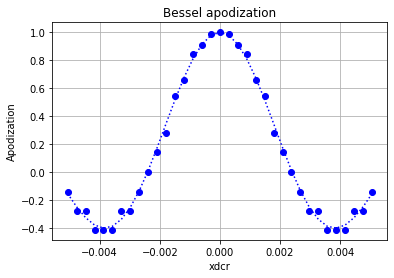

In [6]:
Y, xdcr = get_Bessel_Apodization(aperture=aperture, scale=scale, pitch=0.000298)
apods, n = get_aperture_apodization(Y, fc)


for i in range(len(xdcr)):
    if(Y[i]<0):
        apods[i] = apods[i] * -1

print(apods)
print(n)

fig, ax = plt.subplots()
ax.plot(xdcr, Y, ':b', xdcr, apods, 'ob')
ax.set(xlabel='xdcr', ylabel='Apodization', title='Bessel apodization')
ax.grid()
plt.show()

[0.0, 0.0, 0.14231483827328514, 0.28173255684142967, 0.4154150130018864, 0.6548607339452851, 0.8412535328311811, 0.9096319953545183, 0.9898214418809327, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9898214418809327, 0.9096319953545183, 0.8412535328311811, 0.6548607339452851, 0.4154150130018864, 0.28173255684142967, 0.14231483827328514, 0.0, 0.0]
[0, 0, 2, 4, 6, 10, 14, 16, 20, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 20, 16, 14, 10, 6, 4, 2, 0, 0]


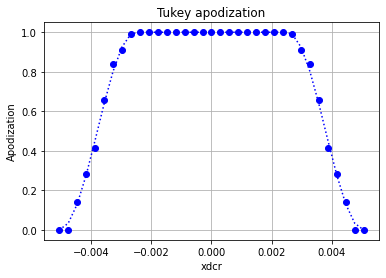

In [9]:
Y, xdcr = get_Tukey_Apodization(aperture=aperture, scale=0.5, pitch=0.000298)
apods, n = get_aperture_apodization(Y, fc)


for i in range(len(xdcr)):
    if(Y[i]<0):
        apods[i] = apods[i] * -1

print(apods)
print(n)

fig, ax = plt.subplots()
ax.plot(xdcr, Y, ':b', xdcr, apods, 'ob')
ax.set(xlabel='xdcr', ylabel='Apodization', title='Tukey apodization')
ax.grid()
plt.show()

In [1]:
A = [2]
print(A[0])

2
